In [1]:
# Cleanup these first three blocks. Consolidate
# Uncomment as needed in your runtime (internet required)
%pip install -q transformers datasets peft accelerate scikit-learn matplotlib seaborn \
              pyfaidx google-cloud-storage cyvcf2

# If using CUDA:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
     print("GPU:", torch.cuda.get_device_name(0))

Note: you may need to restart the kernel to use updated packages.
CUDA available: True
GPU: Tesla T4


In [ ]:
# One-time fixing packages
%pip install -U "transformers>=4.44.2" "accelerate>=0.34.2" "peft>=0.13.2" "datasets>=2.20"

import transformers, torch
print("Transformers:", transformers.__version__)
print("Torch:", torch.__version__)

In [ ]:
# One-time fix for transformers version

%pip uninstall -y transformers
%pip install "transformers==4.44.2"  # known-good, definitely has evaluation_strategy

In [2]:
import os, urllib.request, gzip, shutil, pandas as pd, numpy as np

In [3]:
# Download ClinVar
DATA_DIR = os.environ.get("DATA_DIR", "./data")
os.makedirs(DATA_DIR, exist_ok=True)

# Download ClinVar GRCh38 VCF + index
vcf_url  = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz"
tbi_url  = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz.tbi"
vcf_path = os.path.join(DATA_DIR, "clinvar.vcf.gz")
tbi_path = os.path.join(DATA_DIR, "clinvar.vcf.gz.tbi")

def _dl(url, dest):
    if not os.path.exists(dest):
        print(f"Downloading {url} -> {dest}")
        urllib.request.urlretrieve(url, dest)
    else:
        print(f"Exists: {dest}")

_dl(vcf_url, vcf_path)
_dl(tbi_url, tbi_path)

print("DATA_DIR:", DATA_DIR)
print("VCF ready:", os.path.exists(vcf_path), "Index ready:", os.path.exists(tbi_path))

Exists: ./data/clinvar.vcf.gz
Exists: ./data/clinvar.vcf.gz.tbi
DATA_DIR: ./data
VCF ready: True Index ready: True


In [ ]:
# Filter ClinVar dataset
from cyvcf2 import VCF
import re, csv

# ----- Configs -----
out_csv = os.path.join(DATA_DIR, "clinvar_snvs_clean.csv")

# Map CLNSIG to binary label (1 = pathogenic, 0 = benign); drop everything else
pat_re = re.compile(r"(Pathogenic|Likely_pathogenic)", re.IGNORECASE)
ben_re = re.compile(r"(Benign|Likely_benign)", re.IGNORECASE)

# Optional: keep only higher-confidence review statuses (set to False to keep all)
HIGH_CONF_ONLY = True
good_rev = {
    "criteria_provided,_multiple_submitters,_no_conflicts",
    "reviewed_by_expert_panel",
    "practice_guideline",
}

# Parse
vcf = VCF(vcf_path)
rows = []
kept, skipped_sig, skipped_len, skipped_conf = 0,0,0,0

for rec in vcf:
    # SNVs only
    if not rec.is_snp:
        continue

    clnsig = (rec.INFO.get("CLNSIG") or "").replace(" ", "_")
    rev    = (rec.INFO.get("CLNREVSTAT") or "").replace(" ", "_")
    gene   = (rec.INFO.get("GENEINFO") or "")

    # Binary label mapping
    is_pat = bool(pat_re.search(clnsig))
    is_ben = bool(ben_re.search(clnsig))
    if not (is_pat or is_ben):
        skipped_sig += 1
        continue
    label = 1 if is_pat else 0

    # Optional high-confidence filter
    if HIGH_CONF_ONLY:
        # allow any record whose CLNREVSTAT contains at least one "good" tag
        rv = rev.lower()
        if not any(tag in rv for tag in good_rev):
            skipped_conf += 1
            continue

    # Split multi-allelics; keep only 1bp ref/alt (pure SNVs)
    for alt in rec.ALT or []:
        if len(rec.REF) != 1 or len(alt) != 1:
            skipped_len += 1
            continue

        rows.append({
            "CHROM":   rec.CHROM,      # typically '1'..'22','X','Y','MT'
            "POS":     rec.POS,        # 1-based
            "REF":     rec.REF,
            "ALT":     alt,
            "CLNSIG":  clnsig,
            "CLNREV":  rev,
            "GENEINFO":gene,
            "LABEL":   label           # 1=Pathogenic/Likely_pathogenic, 0=Benign/Likely_benign
        })
        kept += 1

print(f"Kept SNVs: {kept} | dropped (no binary CLNSIG): {skipped_sig} | "
      f"dropped (non-1bp alleles): {skipped_len} | dropped (low-conf rev): {skipped_conf}")

# De-duplicate exact (CHROM,POS,REF,ALT) if desired
df = pd.DataFrame(rows).drop_duplicates(subset=["CHROM","POS","REF","ALT"])
df = df.reset_index(drop=True)
df.to_csv(out_csv, index=False)
print("Saved:", out_csv, "Rows:", len(df))

# Quick sanity checks
print("Label counts:\n", df["LABEL"].value_counts())
print(df.head(5))

In [ ]:
# Print Chromosome counts
df["CHROM"].value_counts()

In [ ]:
# Download Reference
import os, urllib.request, gzip, shutil

REF_DIR = os.path.join(".", "ref")
os.makedirs(REF_DIR, exist_ok=True)

# UCSC hg38 (chr1..chr22, chrX, chrY, chrM) — good match for your CHROM values after mapping MT->chrM
hg38_url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz"
fa_gz    = os.path.join(REF_DIR, "hg38.fa.gz")
fa_path  = os.path.join(REF_DIR, "hg38.fa")

def _dl(url, dest):
    if not os.path.exists(dest):
        print(f"Downloading {url} -> {dest}")
        urllib.request.urlretrieve(url, dest)
    else:
        print(f"Exists: {dest}")

# Download and gunzip (first time only)
_dl(hg38_url, fa_gz)
if not os.path.exists(fa_path):
    print(f"Unzipping {fa_gz} -> {fa_path} (this can take a few minutes)")
    with gzip.open(fa_gz, "rb") as f_in, open(fa_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
else:
    print(f"Exists: {fa_path}")

print("Reference ready:", os.path.exists(fa_path), "| size (GB) ~", round(os.path.getsize(fa_path)/1e9, 2))


In [ ]:
# Load ClinVar SNVs and Normalize Chrom Names (robust dtype handling)
import os
import pandas as pd

DATA_DIR = os.environ.get("DATA_DIR", "./data")
src_csv  = os.path.join(DATA_DIR, "clinvar_snvs_clean.csv")
assert os.path.exists(src_csv), f"Missing: {src_csv} (run the VCF parsing step first)."

# 1) Read as strings to avoid mixed-type inference warnings, then coerce numerics
df = pd.read_csv(
    src_csv,
    dtype=str,            # read everything as string first
    low_memory=False
)

# Clean up any accidental index column
for idx_col in ["Unnamed: 0", "index"]:
    if idx_col in df.columns:
        df = df.drop(columns=[idx_col])

# Strip column-name whitespace just in case
df.columns = df.columns.str.strip()

# 2) Coerce numeric columns
for col, dtype in [("POS", "Int64"), ("LABEL", "Int8")]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype(dtype)

# 3) Normalize chromosome names to UCSC FASTA names
def normalize_chr(chrom: str) -> str:
    """
    Map ClinVar CHROM values to UCSC FASTA names:
      '1' -> 'chr1', ..., '22' -> 'chr22', 'X' -> 'chrX', 'Y' -> 'chrY', 'MT' -> 'chrM'
    If already 'chr*', leave as is.
    """
    if chrom is None or pd.isna(chrom):
        return chrom
    c = str(chrom).strip()
    if not c.startswith("chr"):
        c = "chr" + c
    if c == "chrMT":
        c = "chrM"
    return c

df["CHR_UCSC"] = df["CHROM"].apply(normalize_chr)

print(df[["CHROM", "CHR_UCSC"]].head())
print(df.dtypes)

In [ ]:
# Extract REF/ALT windows (+- FLANK) with pyfaidx
from pyfaidx import Fasta
import numpy as np

# configurable flank (±N bp)
FLANK = 100  # try 50/100/200 as experiments
MAX_ROWS = None  # e.g., set to 5000 for a quick test

fa = Fasta(os.path.join("ref","hg38.fa"), as_raw=True, build_index=True)

def fetch_windows(row, flank=FLANK):
    """
    Returns (ref_window, alt_window) around POS for 1bp REF->ALT.
    Performs a quick sanity check that reference base matches FASTA.
    """
    chrom = row["CHR_UCSC"]
    pos   = int(row["POS"])            # 1-based
    ref   = str(row["REF"])
    alt   = str(row["ALT"])

    # window coordinates inclusive [start, end], 1-based for pyfaidx slicing
    start = max(1, pos - flank)
    end   = pos + flank

    try:
        window = fa[chrom][start:end]  # string slice from FASTA
    except KeyError:
        # chromosome absent in FASTA (shouldn't happen with UCSC hg38)
        return None, None

    window = str(window).upper()
    # check the reference base at center (index relative to 'start')
    center_idx = pos - start
    if center_idx < 0 or center_idx >= len(window):
        return None, None

    # confirm the base matches expectation
    if window[center_idx] != ref.upper():
        # Sometimes reference mismatch can occur due to liftover/outdated positions.
        # For now, skip mismatches to keep dataset clean.
        return None, None

    # build alt window by substituting at the center position
    alt_window = window[:center_idx] + alt.upper() + window[center_idx+1:]

    return window, alt_window

# Apply (optionally on a subset for speed testing)
work_df = df if MAX_ROWS is None else df.head(MAX_ROWS).copy()

ref_windows, alt_windows = [], []
skipped = 0

for i, row in work_df.iterrows():
    r, a = fetch_windows(row, FLANK)
    if r is None or a is None:
        ref_windows.append(np.nan)
        alt_windows.append(np.nan)
        skipped += 1
    else:
        ref_windows.append(r)
        alt_windows.append(a)

work_df["ref_seq"] = ref_windows
work_df["alt_seq"] = alt_windows
work_df = work_df.dropna(subset=["ref_seq","alt_seq"]).reset_index(drop=True)

print(f"Built windows for {len(work_df)} variants; skipped {skipped} due to chromosome/position mismatches.")
print(work_df[["CHROM","POS","REF","ALT","LABEL","ref_seq","alt_seq"]].head())

In [ ]:
# Save ready-to-tokenize dataset
out_csv = os.path.join(DATA_DIR, f"clinvar_seq_pairs_flank{FLANK}.csv")
work_df.to_csv(out_csv, index=False)
print("Saved:", out_csv, "| rows:", len(work_df))

In [ ]:
# Out of ~318 k ClinVar SNVs, ~80 k (25%) aligned perfectly to the reference genome (hg38.fa) after validation. The remaining variants likely represent assembly or coordinate mismatches.
# I'm going to try NCBI's GRCh38 reference instead

In [ ]:
# NCBI GRCh38 (RefSeq) — primary assembly FASTA
# This file includes chromosomes and many scaffolds; we will auto-detect the
# primary chromosomes by parsing headers ('chromosome 1', ..., 'X', 'Y', 'mitochondrion').

import os, urllib.request, gzip, shutil, pathlib

REF_DIR = os.path.join(".", "ref")
os.makedirs(REF_DIR, exist_ok=True)

# RefSeq assembly (p14 as of writing) — update URL if needed later
NCBI_URL = ("https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/"
            "GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_genomic.fna.gz")
ncbi_gz   = os.path.join(REF_DIR, "GRCh38.p14_genomic.fna.gz")
ncbi_fa   = os.path.join(REF_DIR, "GRCh38.p14_genomic.fna")

def _dl(url, dest):
    if not os.path.exists(dest):
        print(f"Downloading {url} -> {dest}")
        urllib.request.urlretrieve(url, dest)
    else:
        print(f"Exists: {dest}")

_dl(NCBI_URL, ncbi_gz)

if not os.path.exists(ncbi_fa):
    print(f"Unzipping {ncbi_gz} -> {ncbi_fa} (this can take a few minutes)")
    with gzip.open(ncbi_gz, "rb") as f_in, open(ncbi_fa, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
else:
    print(f"Exists: {ncbi_fa}")

print("NCBI FASTA ready:", os.path.exists(ncbi_fa), "| size (GB) ~", round(os.path.getsize(ncbi_fa)/1e9, 2))

In [ ]:
from pathlib import Path
import re

fa_path = Path(ncbi_fa)
assert fa_path.exists(), "NCBI FASTA not found — run the previous cell first."

# We'll scan headers to discover accessions and their chromosome names
chrom_to_acc = {}   # e.g., {'1': 'NC_000001.11', '2': 'NC_000002.12', ..., 'MT': 'NC_012920.1'}

want = {str(i) for i in range(1,23)} | {"X","Y","MT"}  # target set

header_re = re.compile(r"^>(\S+).+?(chromosome\s+([0-9XY]{1,2})|mitochondrion)", re.IGNORECASE)

with open(fa_path, "r") as f:
    for line in f:
        if not line.startswith(">"):
            continue
        m = header_re.search(line)
        if not m:
            continue
        acc = m.group(1)
        chrom_label = m.group(3)
        if chrom_label:
            key = chrom_label.upper()
        else:
            # If 'mitochondrion' matched
            key = "MT"
        if key in want and key not in chrom_to_acc:
            chrom_to_acc[key] = acc

print("Discovered chromosome→accession mapping:")
for k in sorted(chrom_to_acc, key=lambda x: (x not in {"X","Y","MT"}, x if x.isdigit() else 100)):
    print(f"  {k:>2} -> {chrom_to_acc[k]}")

missing = want - set(chrom_to_acc.keys())
if missing:
    print("WARNING: Did not find entries for:", missing)

In [4]:
import pandas as pd, os

DATA_DIR = os.environ.get("DATA_DIR", "./data")
src_csv  = os.path.join(DATA_DIR, "clinvar_snvs_clean.csv")
assert os.path.exists(src_csv), f"Missing: {src_csv} (run the VCF parsing step first)."

df = pd.read_csv(src_csv, dtype=str)
# Coerce numerics
df["POS"] = pd.to_numeric(df["POS"], errors="coerce").astype("Int64")
df["LABEL"] = pd.to_numeric(df["LABEL"], errors="coerce").astype("Int8")

def to_ncbi_name(chrom: str) -> str | None:
    """
    Convert ClinVar CHROM ('1'..'22','X','Y','MT') to NCBI accession using parsed map.
    Returns accession string like 'NC_000001.11' or None if unavailable.
    """
    if chrom is None:
        return None
    key = str(chrom).strip().upper()
    return chrom_to_acc.get(key)

df["NCBI_SEQ"] = df["CHROM"].apply(to_ncbi_name)
print(df[["CHROM","NCBI_SEQ"]].head())
print("Rows with missing NCBI mapping:", df["NCBI_SEQ"].isna().sum())
df = df.dropna(subset=["NCBI_SEQ","POS","REF","ALT"]).reset_index(drop=True)

NameError: name 'chrom_to_acc' is not defined

In [5]:
from pyfaidx import Fasta
import numpy as np

FLANK = 100     # adjust (e.g., 50/100/200) as you wish
MAX_ROWS = None # set to small int for quick test, None for all

fa_ncbi = Fasta(str(fa_path), as_raw=True, build_index=True)

def fetch_windows_ncbi(row, flank=FLANK):
    """
    Extract ref/alt windows from NCBI GRCh38 using accession names.
    Validates that REF matches the FASTA at the center position.
    """
    acc = row["NCBI_SEQ"]
    pos = int(row["POS"])   # 1-based
    ref = str(row["REF"]).upper()
    alt = str(row["ALT"]).upper()

    start = max(1, pos - flank)
    end   = pos + flank

    try:
        window = fa_ncbi[acc][start:end]
    except KeyError:
        return None, None

    window = str(window).upper()
    center_idx = pos - start
    if center_idx < 0 or center_idx >= len(window):
        return None, None

    if window[center_idx] != ref:
        return None, None

    alt_window = window[:center_idx] + alt + window[center_idx+1:]
    return window, alt_window

work_df = df if MAX_ROWS is None else df.head(MAX_ROWS).copy()

ref_windows, alt_windows = [], []
skipped = 0
for _, row in work_df.iterrows():
    r, a = fetch_windows_ncbi(row, FLANK)
    if r is None or a is None:
        ref_windows.append(np.nan)
        alt_windows.append(np.nan)
        skipped += 1
    else:
        ref_windows.append(r)
        alt_windows.append(a)

work_df["ref_seq"] = ref_windows
work_df["alt_seq"] = alt_windows
work_df = work_df.dropna(subset=["ref_seq", "alt_seq"]).reset_index(drop=True)

print(f"Built windows for {len(work_df)} variants; skipped {skipped} due to reference mismatches or contigs.")
print(work_df[["CHROM","NCBI_SEQ","POS","REF","ALT","LABEL","ref_seq","alt_seq"]].head())

NameError: name 'fa_path' is not defined

In [ ]:
out_csv_ncbi = os.path.join(DATA_DIR, f"clinvar_seq_pairs_ncbi_flank{FLANK}.csv")
work_df.to_csv(out_csv_ncbi, index=False)
print("Saved:", out_csv_ncbi, "| rows:", len(work_df))

In [6]:
# Prepare data for DNABERT fine-tuning
# Config and Load sequence pairs
import os, pandas as pd

DATA_DIR = os.environ.get("DATA_DIR", "./data")
FLANK = 100
K = 6

src_csv = os.path.join(DATA_DIR, f"clinvar_seq_pairs_ncbi_flank{FLANK}.csv")
assert os.path.exists(src_csv), f"Missing: {src_csv}"

# Read everything as string first; prevents DtypeWarning
df = pd.read_csv(src_csv, dtype=str, low_memory=False)

# Clean stray index cols if present
for c in ("Unnamed: 0", "index"):
    if c in df.columns:
        df = df.drop(columns=[c])

# Coerce numeric columns (nullable dtypes keep NaN if any)
if "POS" in df.columns:
    df["POS"] = pd.to_numeric(df["POS"], errors="coerce").astype("Int64")
if "LABEL" in df.columns:
    df["LABEL"] = pd.to_numeric(df["LABEL"], errors="coerce").astype("Int8")

# Make sure sequence/text columns are strings
for c in ("ref_seq", "alt_seq"):
    if c in df.columns:
        df[c] = df[c].astype("string")

df = df.dropna(subset=["alt_seq", "ref_seq", "LABEL"]).reset_index(drop=True)

print("Loaded rows:", len(df))
print(df.dtypes)
df.head(2)

Loaded rows: 79825
CHROM               object
POS                  Int64
REF                 object
ALT                 object
CLNSIG              object
CLNREV              object
GENEINFO            object
LABEL                 Int8
NCBI_SEQ            object
ref_seq     string[python]
alt_seq     string[python]
dtype: object


,CHROM,POS,REF,ALT,CLNSIG,CLNREV,GENEINFO,LABEL,NCBI_SEQ,ref_seq,alt_seq
0,1,930204,G,A,Benign,"criteria_provided,_multiple_submitters,_no_con...",SAMD11:148398,0,NC_000001.11,CCCACCTTCCTCTCCTCCTGCCCCACCTTCCTCTCCTCCTGCCCCA...,CCCACCTTCCTCTCCTCCTGCCCCACCTTCCTCTCCTCCTGCCCCA...
1,1,930248,G,A,Likely_benign,"criteria_provided,_multiple_submitters,_no_con...",SAMD11:148398,0,NC_000001.11,CACCAGAACCGGGGGCGGCTGGCAGACAAGAGGACAGTCGCCCTGC...,CACCAGAACCGGGGGCGGCTGGCAGACAAGAGGACAGTCGCCCTGC...


In [7]:
# Verifying no whitespace in sequences. Just Jupyter formatting
print(df["ref_seq"].iloc[0])
print(df["alt_seq"].iloc[0])

CCCACCTTCCTCTCCTCCTGCCCCACCTTCCTCTCCTCCTGCCCCACCAGAACCGGGGGCGGCTGGCAGACAAGAGGACAGTCGCCCTGCCTGCCGCCCGGAACCTGAAGAAGGAGCGAACTCCCAGCTTCTCTGCCAGCGATGGTGACAGCGACGGGAGTGGCCCCACCTGTGGGCGGCGGCCAGGCTTGAAGCAGGAG
CCCACCTTCCTCTCCTCCTGCCCCACCTTCCTCTCCTCCTGCCCCACCAGAACCGGGGGCGGCTGGCAGACAAGAGGACAGTCGCCCTGCCTGCCGCCCGAAACCTGAAGAAGGAGCGAACTCCCAGCTTCTCTGCCAGCGATGGTGACAGCGACGGGAGTGGCCCCACCTGTGGGCGGCGGCCAGGCTTGAAGCAGGAG


In [8]:
# k-mer Utilities
import re

VALID = set("ACGT")

def clean_seq(seq: str) -> str:
    """Uppercase and replace any non-ACGT with 'A' (simple, fast)."""
    s = str(seq).upper()
    return "".join(ch if ch in VALID else "A" for ch in s)

def kmerize(seq: str, k: int = 6) -> str:
    """Return space-separated overlapping k-mers (DNABERT input)."""
    s = clean_seq(seq)
    if len(s) < k:
        return ""  # will be dropped later
    return " ".join(s[i:i+k] for i in range(len(s) - k + 1))

In [9]:
# Built DNABERT text columns (ALT Baseline + optional REF)
# ALT-only baseline (recommended first experiment)
df["text_alt_k6"] = df["alt_seq"].map(lambda s: kmerize(s, k=K))

# (Optional) REF text as well, if you plan paired experiments later
df["text_ref_k6"] = df["ref_seq"].map(lambda s: kmerize(s, k=K))

# Drop any rows where k-merization failed (too short, etc.)
before = len(df)
df = df[(df["text_alt_k6"].str.len() > 0)]
after = len(df)
print(f"Dropped {before - after} rows with too-short sequences for k={K}.")
df[["CHROM","POS","REF","ALT","LABEL","text_alt_k6"]].head(2)

Dropped 0 rows with too-short sequences for k=6.


,CHROM,POS,REF,ALT,LABEL,text_alt_k6
0,1,930204,G,A,0,CCCACC CCACCT CACCTT ACCTTC CCTTCC CTTCCT TTCC...
1,1,930248,G,A,0,CACCAG ACCAGA CCAGAA CAGAAC AGAACC GAACCG AACC...


In [10]:
# Stratified train/val split and save CSVs
from sklearn.model_selection import train_test_split

keep_cols = ["CHROM","POS","REF","ALT","LABEL","text_alt_k6","text_ref_k6","ref_seq","alt_seq"]
prepared = df[keep_cols].copy()

train_df, val_df = train_test_split(
    prepared,
    test_size=0.2,
    stratify=prepared["LABEL"],
    random_state=42
)

prep_all  = os.path.join(DATA_DIR, f"prepared_k{K}_alt_only_all.csv")
prep_tr   = os.path.join(DATA_DIR, f"prepared_k{K}_alt_only_train.csv")
prep_val  = os.path.join(DATA_DIR, f"prepared_k{K}_alt_only_val.csv")

prepared.to_csv(prep_all, index=False)
train_df.to_csv(prep_tr, index=False)
val_df.to_csv(prep_val, index=False)

print("Saved:")
print("  ", prep_all, f"(rows={len(prepared)})")
print("  ", prep_tr,  f"(rows={len(train_df)})")
print("  ", prep_val, f"(rows={len(val_df)})")
print("Label balance (all):\n", prepared["LABEL"].value_counts(normalize=True).round(3))

Saved:
   ./data/prepared_k6_alt_only_all.csv (rows=79825)
   ./data/prepared_k6_alt_only_train.csv (rows=63860)
   ./data/prepared_k6_alt_only_val.csv (rows=15965)
Label balance (all):
 LABEL
0    0.836
1    0.164
Name: proportion, dtype: Float64


In [11]:
# Hugging Face Login
# Only needed if your environment blocks anonymous HF downloads
# Get a token from https://huggingface.co/settings/tokens
# and paste it when prompted.
from huggingface_hub import login
try:
    login()  # or login(token="hf_...") to pass programmatically
except Exception as e:
    print("HF login skipped or not required:", e)

In [12]:
# Load DNABERT tokenizer 
from transformers import AutoTokenizer

MODEL_CANDIDATES = [
    "zhihan1996/DNA_bert_6",     # official DNABERT (k=6)
    "armheb/DNA_bert_6",         # public mirror
    # add more fallbacks here if needed
]

tok = None
last_err = None
for mid in MODEL_CANDIDATES:
    try:
        tok = AutoTokenizer.from_pretrained(mid, use_fast=False)  # DNABERT uses a classic BertTokenizer
        MODEL_NAME = mid
        print("Loaded tokenizer from:", mid)
        break
    except Exception as e:
        last_err = e
        print(f"Failed to load {mid}: {e}")

if tok is None:
    raise last_err

# Your existing sanity check
sample = prepared["text_alt_k6"].iloc[0]
enc = tok(sample, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
print("Tokenized input_ids shape:", enc["input_ids"].shape)
print("First 10 tokens:", enc["input_ids"][0, :10].tolist())

tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Loaded tokenizer from: zhihan1996/DNA_bert_6
Tokenized input_ids shape: torch.Size([1, 512])
First 10 tokens: [2, 2703, 2606, 2218, 667, 2655, 2414, 1451, 1694, 2667]


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Now let's train. 
# 1. Baseline full fine-tune
# 2. Weighted Loss (to handle the 83.6/16.4 class imbalance. May address this later
# 3. LoRA 

In [ ]:
# One-time fixing packages
#%pip install -U "transformers>=4.44.2" "accelerate>=0.34.2" "peft>=0.13.2" "datasets>=2.20"

#import transformers, torch
#print("Transformers:", transformers.__version__)
#print("Torch:", torch.__version__)

In [ ]:
# One-time fix for transformers version

#%pip uninstall -y transformers
#%pip install "transformers==4.44.2"  # known-good, definitely has evaluation_strategy

In [13]:
from transformers import TrainingArguments
import inspect
"evaluation_strategy" in inspect.signature(TrainingArguments.__init__).parameters
# should print: True

True

In [15]:
# 1. Baseline full fine-tune
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

MODEL_NAME = mid  # from the tokenizer cell you just ran
tokenizer = tok
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

class KmerTextDataset(Dataset):
    def __init__(self, df, text_col="text_alt_k6", label_col="LABEL", max_length=512):
        self.texts = df[text_col].tolist()
        self.labels = df[label_col].astype(int).tolist()
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = KmerTextDataset(train_df)
val_ds   = KmerTextDataset(val_df)

from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_classification_metrics(y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return {"auc": auc, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def hf_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:,1].numpy()
    return compute_classification_metrics(labels, probs)

training_args = TrainingArguments(
    output_dir="./runs/dnabert_fullft",
    num_train_epochs=1,                 # start with 1 for smoke test; then 3–5
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=2e-5,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="auc",        # since your compute_metrics returns 'auc'
    greater_is_better=True,
    report_to=[],                       # avoids wandb/autologging surprises
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=hf_compute_metrics,
)

trainer.train()   # <-- run when ready
preds = trainer.predict(val_ds)
y_prob = torch.softmax(torch.tensor(preds.predictions), dim=1)[:,1].numpy()
metrics = compute_classification_metrics(preds.label_ids, y_prob); metrics

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNA_bert_6 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Auc,Accuracy,Precision,Recall,F1
1,0.380500,0.369016,0.797503,0.852928,0.612745,0.285823,0.389813


{'auc': 0.7975033924852966,
 'accuracy': 0.8529282806138427,
 'precision': 0.6127450980392157,
 'recall': 0.2858231707317073,
 'f1': 0.3898128898128898}

In [16]:
# === Early-stopping training run (max 5 epochs) ===
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback
import torch, pandas as pd

# Callback to capture per-epoch metrics cleanly
class MetricHistory(TrainerCallback):
    def __init__(self):
        self.rows = []
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is None: 
            return
        row = {"epoch": state.epoch}
        # keep the common ones if present
        for k in ["eval_auc","eval_f1","eval_accuracy","eval_precision","eval_recall","eval_loss"]:
            if k in metrics: row[k] = metrics[k]
        self.rows.append(row)

hist = MetricHistory()

training_args_es = TrainingArguments(
    output_dir="./runs/dnabert_fullft_es",
    num_train_epochs=5,                 # upper bound
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="auc",
    greater_is_better=True,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    report_to=[],
)

trainer_es = Trainer(
    model=model,                        # continues from your current model (after 1 epoch)
    args=training_args_es,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=hf_compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=2,          # stop after 2 epochs w/o sufficient AUC gain
            early_stopping_threshold=0.002      # min AUC improvement to count as “better”
        ),
        hist
    ],
)

# Train with early stopping
train_output = trainer_es.train()

# Show per-epoch validation metrics
df_hist = pd.DataFrame(hist.rows).sort_values("epoch")
display(df_hist)

# Evaluate the best checkpoint on the validation set
preds_es = trainer_es.predict(val_ds)
y_prob_es = torch.softmax(torch.tensor(preds_es.predictions), dim=1)[:,1].numpy()
metrics_es = compute_classification_metrics(preds_es.label_ids, y_prob_es)
print("Best-checkpoint metrics:", metrics_es)

# (Optional) save the history for your report
df_hist.to_csv("./runs/dnabert_fullft_es/val_metrics_by_epoch.csv", index=False)
print("Saved per-epoch metrics -> ./runs/dnabert_fullft_es/val_metrics_by_epoch.csv")

Epoch,Training Loss,Validation Loss,Auc,Accuracy,Precision,Recall,F1
1,0.364100,0.355586,0.836388,0.857626,0.584497,0.462652,0.516486
2,0.352100,0.332220,0.871593,0.879173,0.713059,0.443216,0.546651
3,0.261400,0.432063,0.880534,0.884435,0.712958,0.496951,0.585673
4,0.220900,0.464837,0.881413,0.886502,0.703407,0.535061,0.607792
5,0.210000,0.532064,0.878959,0.886564,0.693295,0.555640,0.616882


,epoch,eval_auc,eval_f1,eval_accuracy,eval_precision,eval_recall,eval_loss
0,1.0,0.836388,0.516486,0.857626,0.584497,0.462652,0.355586
1,2.0,0.871593,0.546651,0.879173,0.713059,0.443216,0.332220
2,3.0,0.880534,0.585673,0.884435,0.712958,0.496951,0.432063
3,4.0,0.881413,0.607792,0.886502,0.703407,0.535061,0.464837
4,5.0,0.878959,0.616882,0.886564,0.693295,0.555640,0.532064


Best-checkpoint metrics: {'auc': 0.8814127141756296, 'accuracy': 0.8865017225180082, 'precision': 0.7034068136272545, 'recall': 0.5350609756097561, 'f1': 0.6077922077922078}
Saved per-epoch metrics -> ./runs/dnabert_fullft_es/val_metrics_by_epoch.csv


In [2]:
# Save Epoch 4 or model with best AUC due to class imbalance 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

best_ckpt = "./runs/dnabert_fullft_es/checkpoint-31932"

tokenizer = AutoTokenizer.from_pretrained(best_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(best_ckpt)

save_dir = "./runs/dnabert_fullft_es/best_model"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Saved best model from Epoch 4 → {save_dir}")

✅ Saved best model from Epoch 4 → ./runs/dnabert_fullft_es/best_model


Validation metrics (reloaded model):
  auc: 0.881419
  accuracy: 0.886502
  precision: 0.703407
  recall: 0.535061
  f1: 0.607792


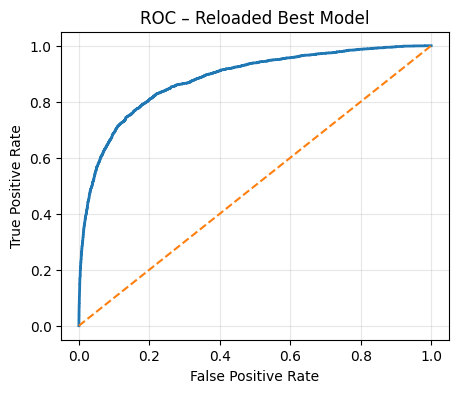

In [3]:
# --- Reload best model and re-evaluate on validation CSV ---

import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, roc_curve
import matplotlib.pyplot as plt

# 1) Paths – EDIT if needed
DATA_DIR = os.environ.get("DATA_DIR", "./data")
VAL_CSV  = os.path.join(DATA_DIR, "prepared_k6_alt_only_val.csv")
BEST_DIR = "./runs/dnabert_fullft_es/best_model"   # or "./runs/dnabert_fullft_es/checkpoint-31932"

assert os.path.exists(VAL_CSV), f"Missing val CSV: {VAL_CSV}"
assert os.path.isdir(BEST_DIR), f"Missing model dir: {BEST_DIR}"

# 2) Reload tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(BEST_DIR, use_fast=False)  # DNABERT tokenizer is classic (non-fast)
model = AutoModelForSequenceClassification.from_pretrained(BEST_DIR)
model.eval()  # put in inference mode

# (Optional) "Freeze" weights if you want to guarantee no grads by accident:
for p in model.parameters():
    p.requires_grad = False

# 3) Validation dataset wrapper (must match how we trained)
class KmerTextDataset(Dataset):
    def __init__(self, df, text_col="text_alt_k6", label_col="LABEL", max_length=512):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].astype(int).tolist()
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

val_df = pd.read_csv(VAL_CSV)
val_ds = KmerTextDataset(val_df)

# 4) Metrics
def compute_classification_metrics(y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return {"auc": auc, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

def hf_compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    return compute_classification_metrics(labels, probs)

# 5) Use a lightweight Trainer for evaluation
args = TrainingArguments(
    output_dir="./runs/tmp_eval",
    per_device_eval_batch_size=32,
    dataloader_drop_last=False,
    report_to=[],  # no logging integrations
)

trainer = Trainer(model=model, args=args, tokenizer=tokenizer)

# Predict on val set
preds = trainer.predict(val_ds)
y_prob = torch.softmax(torch.tensor(preds.predictions), dim=1)[:, 1].numpy()
metrics = compute_classification_metrics(preds.label_ids, y_prob)
print("Validation metrics (reloaded model):")
for k, v in metrics.items():
    print(f"  {k}: {v:.6f}")

# 6) (Optional) ROC curve
fpr, tpr, _ = roc_curve(preds.label_ids, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC – Reloaded Best Model")
plt.grid(True, alpha=0.3)
plt.show()